In [1]:
import numpy as np
import time
import random
from pathlib import Path
import tracemalloc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import tracemalloc

# Algorithme 1 : DP (Memo)

In [2]:
class Knapsack:
    def __init__ ( self,c, valeurs, poids):
        self.cap = c
        self.valeurs = valeurs
        self.poids = poids
        self.mem={}
    def knapsack(self,i, c, poids, valeur, memo):
        if i == len(poids):
            return 0
        if (i, c) in memo:
            return memo[(i, c)]
        if poids[i] > c:
            res = self.knapsack(i + 1, c, poids, valeur, memo)
        else:
            res = max(self.knapsack(i + 1, c, poids, valeur, memo),
                    valeur[i] + self.knapsack(i + 1, c - poids[i], poids, valeur, memo))
        memo[(i, c)] = res
        return res

    def solve(self):
        return self.knapsack(0,self.cap,self.poids,self.valeurs,self.mem)
        


# Algorithme 2 : Recuit Simulé

In [4]:
class RecurSimule:
    def __init__(self, cap, values, weights): # Initialisation des données
        self.capacity = cap
        self.values = values
        self.weights = weights
        self.objects = [((v, w), i) for i, (v, w) in enumerate(zip(values, weights))]
        self.best_solution=0
        self.best_value=0
       

    def initial_solution(self):
        solution = []
        items = self.objects.copy()
        c = self.capacity
        while c > 0 and len(items) > 1:
            myobject = items.pop(np.random.randint(0, len(items)-1))
            if myobject[0][1] <= c:
                solution.append(myobject[1])
            c -= myobject[0][1]
        return solution

    def voisinage(self,solution):

        objects_no_solution = [i for i in range(len(self.objects)) if i not in solution]
        o = objects_no_solution.pop(random.randint(0, len(objects_no_solution)-1))
        solution.append(o)
        if len(solution) == 1:
            return solution
        while self.evalution_weight(solution) > self.capacity and len(solution) > 1:
            solution.pop(random.randint(0, len(solution)-2))
        return solution
    def Metro_criterion(self, delta, t):
          
          return random.random() < np.exp(delta/t)

    def evaluation_values(self, solution):
            val = 0
            for obj in solution:
                val += self.objects[obj][0][0]
            return val

    def evalution_weight(self, solution):

        weight = 0
        for obj in solution:
            weight += self.objects[obj][0][1]
        return weight
    
    def temperature(self,t,k,step=10):
        return t - (k%step == 0) * step

    def solve(self, T0=300):
        S0 = self.initial_solution()
        t = T0
        i = 0
        last_best = 0
        max_iter = 1000
        self.best_solution  = S0
        self.best_value = self.evaluation_values(self.best_solution)
        while i < max_iter and t > 0:
            S1 = self.voisinage(S0)
            delta = self.evaluation_values(S1) - self.evaluation_values(S0)
            if delta > 0:
                S0 = S1
            elif self.Metro_criterion(delta, t):
                S0 = S1
            if self.evaluation_values(S0) > self.best_value:
                self.best_solution = S0.copy()
                self.best_value = self.evaluation_values(self.best_solution)
            
            t = self.temperature(t, i)
            i += 1
        return sum(self.values[self.best_solution])
    
capacite = 10
values = np.array([40, 50, 100, 95, 30])
weights = np.array([2, 3, 1, 5, 3])
kpp = RecurSimule(capacite, values, weights)
kpp.solve()


245


# Algorithme 3 : Génétique

In [82]:
class Genetic:
    def __init__(self, cap, valeurs, poids, taille_pop=50, coef_filtre=40, proba=0.3):
        self.capacity = cap
        self.valeurs = valeurs
        self.poids = poids
        self.n = len(valeurs)
        self.taille_pop = taille_pop
        self.coef_filtre = coef_filtre
        self.proba = proba
        self.population = []

    def total_weight(self, individu):
        return sum(self.poids[i] for i in range(self.n) if individu[i] == 1)

    def fitness(self, individu):
        return sum(self.valeurs[i] for i in range(self.n) if individu[i] == 1)

    def genere_pop(self):
        while len(self.population) < self.taille_pop:
            individu = [random.randint(0, 1) for _ in range(self.n)]
            while self.total_weight(individu) > self.capacity:
                individu[random.randint(0, self.n - 1)] = 0
            self.population.append(individu)

    def filtre(self):
        self.population.sort(key=self.fitness, reverse=True)
        k = int(self.taille_pop * self.coef_filtre / 100)
        self.population = self.population[:self.taille_pop - k]

    def cross_over(self):
        enfants = []
        k = int(self.taille_pop * self.coef_filtre / 100)
        for _ in range(k):
            p1, p2 = random.sample(self.population, 2)
            point = random.randint(1, self.n - 1)
            enfant = p1[:point] + p2[point:]
            while self.total_weight(enfant) > self.capacity:
                enfant[random.randint(0, self.n - 1)] = 0
            enfants.append(enfant)
        return enfants

    def mutation(self, enfants):
        for enfant in enfants:
            for i in range(self.n):
                if random.random() < self.proba:
                    enfant[i] = 1 - enfant[i]
            while self.total_weight(enfant) > self.capacity:
                enfant[random.randint(0, self.n - 1)] = 0
        self.population.extend(enfants)

    def solve(self, generations=100):
        self.genere_pop()
        for _ in range(generations):
            self.filtre()
            enfants = self.cross_over()
            self.mutation(enfants)
        best = max(self.population, key=self.fitness)
        return self.fitness(best)


# Algorithme 4 : Branch Et Bound

In [6]:
class TreeNode:
    def __init__(self, level, V, W, taken):
        self.level = level
        self.V = V
        self.W = W
        self.taken = taken

class KPBB:
    def __init__(self, cap, valeurs, poids):
        self.cap = cap
        self.valeurs = valeurs
        self.poids = poids
        self.n = len(valeurs)
        self.objets = sorted([(v, w, i) for i, (v, w) in enumerate(zip(valeurs, poids))], key=lambda x: x[0]/x[1], reverse=True)

    def bound(self, node):
        if node.W >= self.cap:
            return 0
        value_bound = node.V
        j = node.level
        totweight = node.W
        while j < self.n and totweight + self.objets[j][1] <= self.cap:
            totweight += self.objets[j][1]
            value_bound += self.objets[j][0]
            j += 1
        if j < self.n:
            value_bound += (self.cap - totweight) * self.objets[j][0] / self.objets[j][1]
        return value_bound

    def solve(self):
        queue = []
        root = TreeNode(0, 0, 0, [])
        queue.append(root)
        max_val = 0
        while queue:
            node = queue.pop()  
            if node.level == self.n:
                continue
            v, w, idx = self.objets[node.level]
            # Include
            new_W = node.W + w
            if new_W <= self.cap:
                new_V = node.V + v
                if new_V > max_val:
                    max_val = new_V
                queue.append(TreeNode(node.level + 1, new_V, new_W, node.taken + [idx]))
            # Exclude
            if self.bound(TreeNode(node.level + 1, node.V, node.W, node.taken)) > max_val:
                queue.append(TreeNode(node.level + 1, node.V, node.W, node.taken))
        return max_val


# Benchmark

In [21]:
def compute_time_memo(algo):
    tracemalloc.start()
    start_time = time.time()
    result = algo.solve()
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return result, round(end_time - start_time, 3), round(peak / 1024, 2)

In [206]:
def execute_all(directory,Algorithme1,Algorithme2):
    p=Path('./instances_01_KP/'+directory)
    temps={}
    memoire={}
    opti={}
    for f in p.iterdir():
        first_row=np.loadtxt(f.absolute(),max_rows=1)
        fich=np.loadtxt(f.absolute(),max_rows=int(first_row[0])+1)
        clf1=Algorithme1(fich[0][1],fich[1:,0],fich[1:,1])
        clf2=Algorithme2(fich[0][1],fich[1:,0],fich[1:,1])
        vale_calcul1, time_1, mem_1=compute_time_memo(clf1)
        vale_calcul2, time_2, mem_2=compute_time_memo(clf2)
        temps[f.name]=[time_1,time_2]
        memoire[f.name]=[mem_1,mem_2]
        opti[f.name]=[vale_calcul1,vale_calcul2]
    return temps,memoire,opti

# Exacte

In [169]:

temps,memm,val=execute_all('low-dimensional',Knapsack,KPBB)

In [208]:
def visuale (temps,memm,algo1,algo2):
      # Création de la figure
      plt.subplots(1,2,figsize=(12, 6))
      plt.suptitle('Methodes Approximatives')
      for i in [0,1]:
          plt.subplot(1,2,i+1)
          # Extraire uniquement le premier élément de chaque liste
          values1 = {k: v[i] for k, v in temps.items()}  # Premier élément de data1
          values2 = {k: v[i] for k, v in memm.items()}  # Premier élément de data2

          # Création des listes pour le graphique
          labels = list(values1.keys())  # Les indices (noms)
          valeurs1 = list(values1.values())  # Valeurs du premier dictionnaire
          valeurs2 = list(values2.values())  # Valeurs du second dictionnaire

          # Paramètres pour placer les barres côte à côte
          bar_width = 0.4
          x = np.arange(len(labels))



          # Tracé des barres
          plt.bar(x - bar_width / 2, valeurs1, width=bar_width, label=algo1, color='blue')
          plt.bar(x + bar_width / 2, valeurs2, width=bar_width, label=algo2, color='orange')

          # Ajout des labels et titres
          plt.xticks(x, labels, rotation=45, ha='right')
          plt.xlabel("Index")
          plt.ylabel("Valeur du premier élément")
          if i==0:
            plt.title("Comparaison des Temps d'execution")
          else:
            plt.title("Comparaison des occupation mémoire")
          plt.legend()
          plt.yscale('log')
          plt.grid(axis='y', linestyle='--', alpha=0.7)

      # Affichage du graphique
      plt.show()


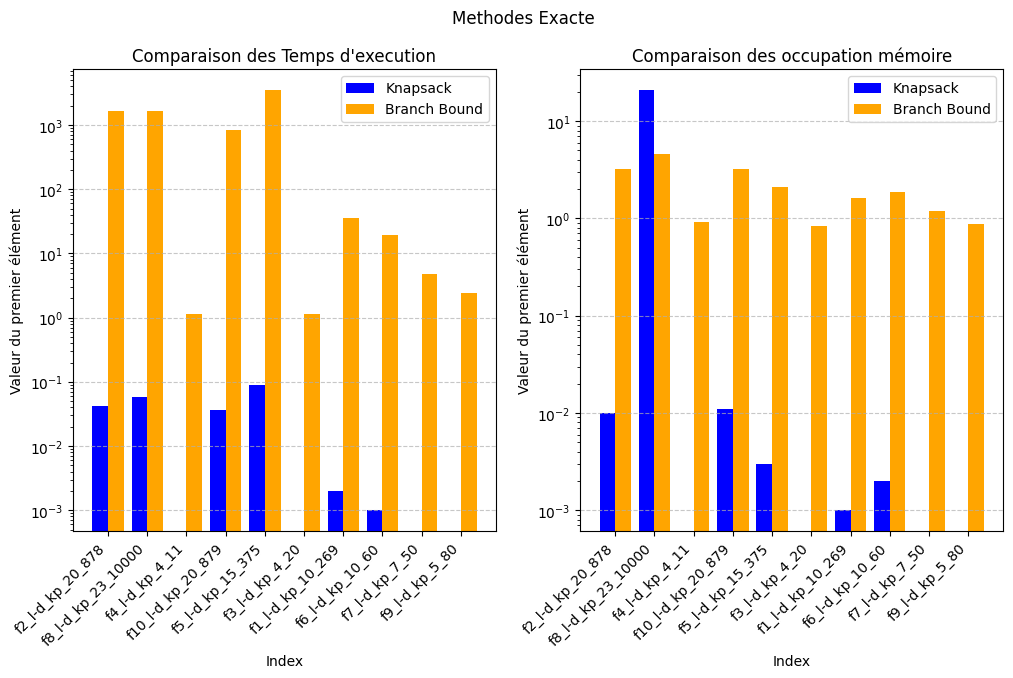

In [173]:
visuale(temps,memm,'Knapsack','Branch Bound')

# Approximation

In [207]:
temps,memm,valeur_predi=execute_all('low-dimensional',RecurSimule,Genetic)

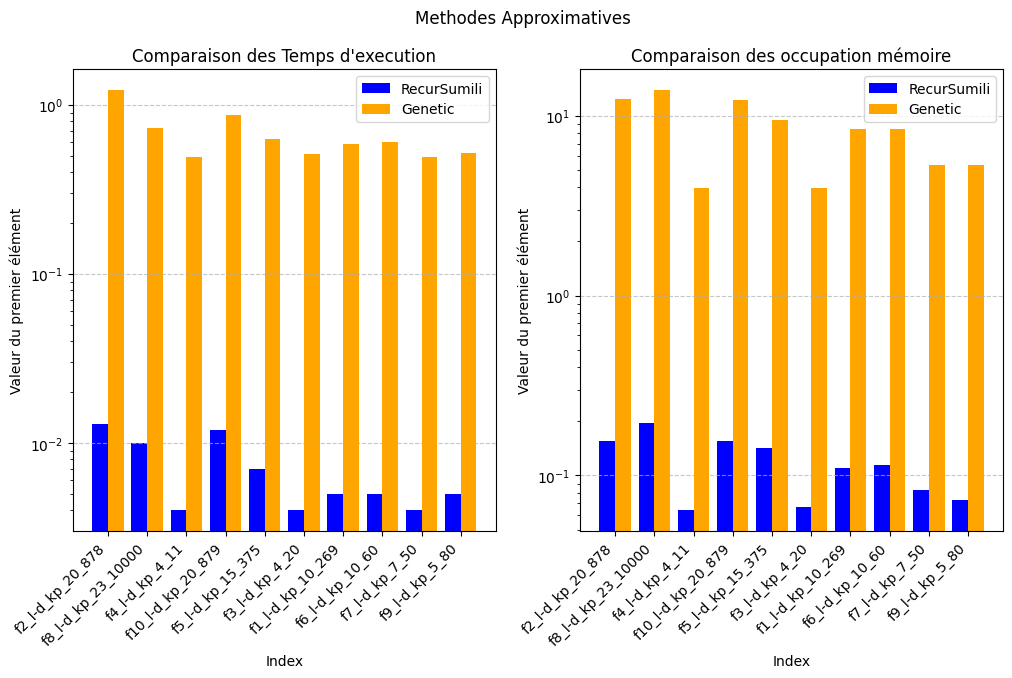

In [209]:
visuale(temps,memm,'RecurSumili','Genetic')

In [ ]:
# low-dimensional-optimum

In [186]:
p=Path('./instances_01_KP/'+'low-dimensional-optimum')
valeurs_reel={}
for f in p.iterdir():
    first_row=np.loadtxt(f.absolute(),max_rows=1)
    valeurs_reel[f.name]=int(first_row)

In [189]:
cle=valeurs_reel.keys()
Erreur={i:np.abs(np.array(valeur_predi[i])-valeurs_reel[i]) for i in cle}

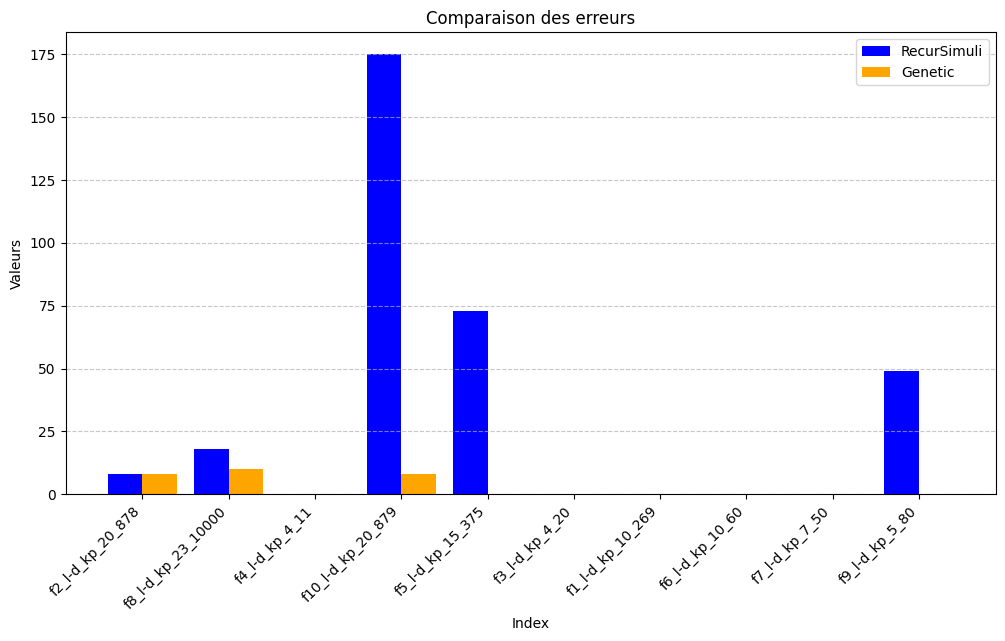

In [193]:
labels = list(Erreur.keys())  # Index (noms des variables)
valeurs1 = [v[0] for v in Erreur.values()]  # Premier élément de chaque array
valeurs2 = [v[1] for v in Erreur.values()]  # Deuxième élément de chaque array

# Paramètres pour placer les barres côte à côte
bar_width = 0.4
x = np.arange(len(labels))

# Création de la figure
plt.figure(figsize=(12, 6))

# Tracé des barres pour chaque série de valeurs
plt.bar(x - bar_width/2, valeurs1, width=bar_width, label='RecurSimuli', color='blue')
plt.bar(x + bar_width/2, valeurs2, width=bar_width, label='Genetic', color='orange')

# Ajout des labels et titres
plt.xticks(x, labels, rotation=45, ha='right')
plt.xlabel("Index")
plt.ylabel("Valeurs")
plt.title("Comparaison des erreurs")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Affichage du graphique
plt.show()

In [195]:
def execute_all(directory):
    p=Path('./instances_01_KP/'+directory)
    temps={}
    memoire={}
    for f in p.iterdir():
        first_row=np.loadtxt(f.absolute(),max_rows=1)
        fich=np.loadtxt(f.absolute(),max_rows=int(first_row[0])+1)
        clf1=Knapsack(fich[0][1],fich[1:,0],fich[1:,1])
        clf2=KPBB(fich[0][1],fich[1:,0],fich[1:,1])
        clf3=RecurSimule(fich[0][1],fich[1:,0],fich[1:,1])
        clf4=Genetic(fich[0][1],fich[1:,0],fich[1:,1])
        vale_calcul1, time_1, mem_1=compute_time_memo(clf1)
        vale_calcul2, time_2, mem_2=compute_time_memo(clf2)
        vale_calcul3, time_3, mem_3=compute_time_memo(clf3)
        vale_calcul4, time_4, mem_4=compute_time_memo(clf4)
        temps[f.name]=[np.mean([time_1,time_2]),np.mean([time_3,time_4])]
        memoire[f.name]=[np.mean([mem_1,mem_2]),np.mean([mem_3,mem_4])]
        
    return temps,memoire

In [196]:
temps_moy,memm_moy=execute_all('low-dimensional')

In [197]:
temps_moy

{'f2_l-d_kp_20_878': [0.026999999999999996, 0.08650000000000001],
 'f8_l-d_kp_23_10000': [10.313, 0.10600000000000001],
 'f4_l-d_kp_4_11': [0.0, 0.035],
 'f10_l-d_kp_20_879': [0.025500000000000002, 0.08600000000000001],
 'f5_l-d_kp_15_375': [0.049, 0.079],
 'f3_l-d_kp_4_20': [0.0, 0.036000000000000004],
 'f1_l-d_kp_10_269': [0.0015, 0.059500000000000004],
 'f6_l-d_kp_10_60': [0.0015, 0.064],
 'f7_l-d_kp_7_50': [0.0, 0.0425],
 'f9_l-d_kp_5_80': [0.0, 0.039]}

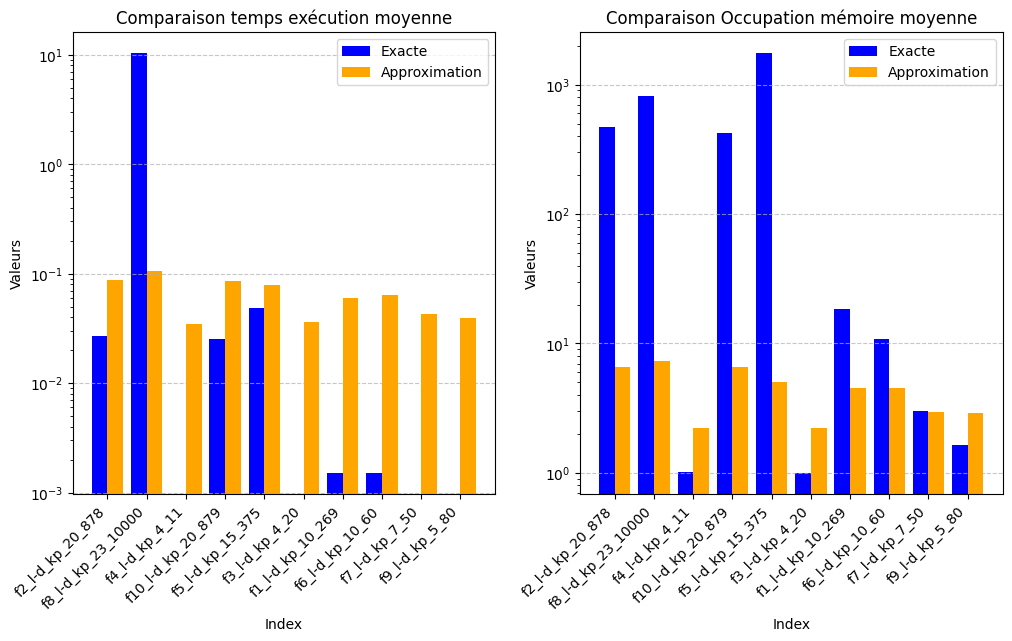

In [204]:
plt.subplots(1,2,figsize=(12, 6))
for i,data in enumerate([temps_moy,memm_moy]):
    labels = list(Erreur.keys())  # Index (noms des variables)
    valeurs1 = [v[0] for v in data.values()]  # Premier élément de chaque array
    valeurs2 = [v[1] for v in data.values()]  # Deuxième élément de chaque array
    
    # Paramètres pour placer les barres côte à côte
    bar_width = 0.4
    x = np.arange(len(labels))
    # Création de la figure
    plt.subplot(1,2,i+1)
    if i==0:
        plt.title('Comparaison temps exécution moyenne')
    else:
        plt.title('Comparaison Occupation mémoire moyenne')

    # Tracé des barres pour chaque série de valeurs
    plt.bar(x - bar_width/2, valeurs1, width=bar_width, label='Exacte', color='blue')
    plt.bar(x + bar_width/2, valeurs2, width=bar_width, label='Approximation', color='orange')

    # Ajout des labels et titres
    plt.yscale('log')
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.xlabel("Index")
    plt.ylabel("Valeurs")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Affichage du graphique
plt.show()